In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
NUM_CLASES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASES,
                            cluster_std=1.5,
                            random_state=42)

In [3]:
# On a classification problem, the labels should be of type long
X = torch.from_numpy(X_blob).type(torch.float32).to('cuda')
y = torch.from_numpy(y_blob).type(torch.LongTensor).to('cuda')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

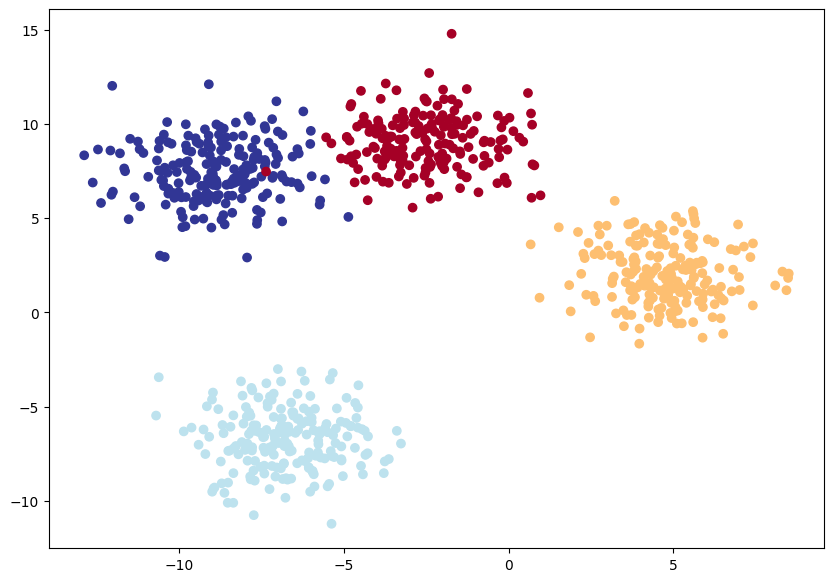

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap=plt.cm.RdYlBu);

In [6]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [7]:
torch.unique(y).shape[0]

4

In [8]:
model = BlobModel(input_features=X.shape[1], output_features=torch.unique(y).shape[0]).to('cuda')

In [9]:
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
#  nn.CrossEntropyLoss() already has a softmax implemented!!!!!
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [11]:
model.eval()
with torch.inference_mode():
    first_preds = model(X_test)
first_preds[:5]

tensor([[-0.2998, -0.3917, -0.1284, -0.0909],
        [-0.1388, -0.4428, -0.2397, -0.1807],
        [-0.8930, -0.9518, -0.4259, -1.0770],
        [-0.1014, -0.4051, -0.2727, -0.2117],
        [-0.1113, -0.4317, -0.2669, -0.2208]], device='cuda:0')

In [12]:
torch.argmax(first_preds[:5], dim=1)

tensor([3, 0, 2, 0, 0], device='cuda:0')

In [13]:
torch.softmax(first_preds[:5], dim=1)

tensor([[0.2309, 0.2106, 0.2740, 0.2845],
        [0.2777, 0.2049, 0.2511, 0.2663],
        [0.2288, 0.2157, 0.3651, 0.1904],
        [0.2877, 0.2123, 0.2424, 0.2576],
        [0.2875, 0.2087, 0.2461, 0.2577]], device='cuda:0')

In [14]:
torch.sum(torch.softmax(first_preds[:5], dim=1), dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

### At the end of the model we have a number of every output unit. We can turn those numbers into probabilities using softmax

In [15]:
torch.argmax(torch.softmax(first_preds[:5], dim=1), dim=1)

tensor([3, 0, 2, 0, 0], device='cuda:0')

In [16]:
torch.argmax(torch.softmax(first_preds, dim=1), dim=1) == y_test

tensor([False, False,  True,  True, False,  True, False,  True,  True, False,
        False, False, False,  True, False, False,  True, False, False, False,
         True,  True, False, False, False,  True, False,  True,  True, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True, False,  True, False,
        False,  True, False, False,  True, False, False, False,  True,  True,
        False,  True, False, False, False, False,  True, False, False, False,
         True, False, False, False,  True, False, False,  True, False, False,
         True,  True, False, False, False, False,  True, False, False, False,
        False,  True, False,  True,  True,  True, False, False, False, False,
        False,  True, False, False,  True,  True, False, False,  True, False,
         True, False, False,  True,  True, False, False, False,  True,  True,
         True,  True, False, False,  True,  True, False, False, 

In [17]:
torch.sum(torch.argmax(torch.softmax(first_preds, dim=1), dim=1) == y_test) / len(y_test)

tensor(0.3450, device='cuda:0')

In [18]:
def accuracy_fn(output, target):
    # coincidences = torch.argmax(torch.softmax(output, dim=1), dim=1) == target
    coincidences = output == target
    return torch.sum(coincidences) / len(y_test)

In [19]:
epochs = 100

for epoch in range(epochs):
    model.train()
    pred_logits_step = model(X_train)
    predicted_label_step = torch.argmax(torch.softmax(pred_logits_step, dim=1), dim=1).type(torch.float32)
    # print(f"Preds in device: {pred_logits_step.device}")
    # print(f"Labels in device: {y_train.device}")
    loss = loss_fn(pred_logits_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        pred_logits_test = model(X_test)
        predicted_label_test = torch.argmax(torch.softmax(pred_logits_test, dim=1), dim=1) 
        
        loss = loss_fn(pred_logits_test, y_test)
        accuracy = accuracy_fn(predicted_label_test, y_test) * 100
        print(f"Epoch {epoch}, loss: {loss.item()}, accuracy: {accuracy:.4f}%")

Epoch 0, loss: 0.9580075144767761, accuracy: 71.5000%
Epoch 10, loss: 0.09290820360183716, accuracy: 97.5000%
Epoch 20, loss: 0.046622134745121, accuracy: 98.0000%
Epoch 30, loss: 0.01605338416993618, accuracy: 99.0000%
Epoch 40, loss: 0.011929018422961235, accuracy: 99.0000%
Epoch 50, loss: 0.019009102135896683, accuracy: 99.0000%
Epoch 60, loss: 0.014790636487305164, accuracy: 99.0000%
Epoch 70, loss: 0.015065393410623074, accuracy: 99.0000%
Epoch 80, loss: 0.015528022311627865, accuracy: 99.0000%
Epoch 90, loss: 0.01585383340716362, accuracy: 99.0000%


In [20]:
model.eval()
with torch.inference_mode():
    pred_logits = model(X_test)
    predicted_label = torch.softmax(pred_logits, dim=1).argmax(dim=1)
predicted_label[:5]

tensor([0, 3, 2, 0, 1], device='cuda:0')

In [21]:
y_test[:5]

tensor([0, 3, 2, 0, 1], device='cuda:0')

In [22]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor, last_activation=lambda x: x):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # mashgrid creates all possible coordinates from a combination of linspaces

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    # ravel flattens the tensor into 1 dimension
    # column stack stacks the arrays in 2 different columns
    # (creates a matrix of shape (len(xx) x 2), len(xx) == len(yy)

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        # y_pred = torch.round(y_logits)
        y_pred = torch.round(last_activation(y_logits))
        # y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


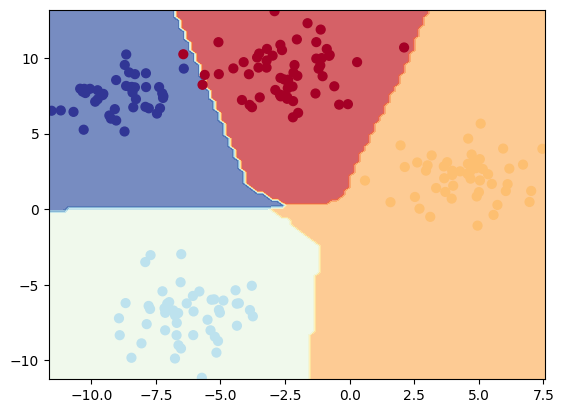

In [23]:
plot_decision_boundary(model, X_test, y_test)

In [24]:
from torchmetrics import Accuracy

In [25]:
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to('cuda')

torchmetric_accuracy(predicted_label, y_test)

tensor(0.9900, device='cuda:0')